**BEM-VINDO!**

Inicialmente, devemos esclarecer que, por mais que seu significa a princípio esteja ligado à consumidores, durante esse código utilizaremos o termo "churn" como definição para a saída precoce de um atleta da NBA, sendo precoce uma atuação em anos inferior à média da década.

Este colab utilizará como referência o FMF, principalmente o que tange à transformação de dados: https://www.kaggle.com/code/kmalit/bank-customer-churn-prediction/notebook

#Requerimentos

In [ ]:
import numpy as np
import pandas as pd

import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, log_loss
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Dados

In [ ]:
path = '/content/combined.csv'
df = pd.read_csv(path)

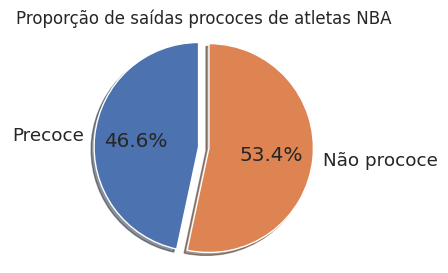

In [ ]:
# Percebemos que a proporção de "churn" não é desequilibrada
labels = 'Precoce', 'Não prococe'
sizes = [df.churn[df['churn']==1].count(), df.churn[df['churn']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(5, 3))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proporção de saídas prococes de atletas NBA", size = 12)
plt.show()

In [ ]:
df.head()

,Player,careers,Pos,Tm,G,PER,GS,MP,TS,OWS,...,P3,year_start,year_end,height,weight,birth_date,year_active,age_start,age_end,churn
0,A.C. Green,18,PF,MIA,1361,13.9,905,39044,0.5,3.4,...,0.1,1986,2001,6-9,220,1963,16,23,38,0
1,A.J. English,2,SG,WSB,151,11.6,18,3108,0.5,-0.2,...,0.1,1991,1992,6-3,175,1967,2,24,25,1
2,A.J. Guyton,3,PG,GSW,80,4.4,14,1246,0.3,0.1,...,0.3,2001,2003,6-1,180,1978,3,23,25,1
3,A.J. Hammons,1,C,DAL,22,8.4,0,163,0.5,-0.2,...,0.5,2017,2017,7-0,260,1992,1,25,25,1
4,A.J. Price,9,PG,PHO,287,10.4,25,4253,0.4,0.1,...,0.2,2010,2015,6-2,181,1986,6,24,29,0


In [ ]:
df.shape  # Temos então 2294 atletas e originalmente 25 atributos associados a eles

(2294, 25)

In [ ]:
df.isnull().sum() # Não há valores nulos nos dados

Player         0
careers        0
Pos            0
Tm             0
G              0
PER            0
GS             0
MP             0
TS             0
OWS            0
DWS            0
WS             0
BPM            0
FG             0
P2             0
P3             0
year_start     0
year_end       0
height         0
weight         0
birth_date     0
year_active    0
age_start      0
age_end        0
churn          0
dtype: int64

In [ ]:
df.dtypes # Percebe-se que há em maior parte dados númericos

Player          object
careers          int64
Pos             object
Tm              object
G                int64
PER            float64
GS               int64
MP               int64
TS             float64
OWS            float64
DWS            float64
WS             float64
BPM            float64
FG             float64
P2             float64
P3             float64
year_start       int64
year_end         int64
height          object
weight           int64
birth_date       int64
year_active      int64
age_start        int64
age_end          int64
churn            int64
dtype: object

In [ ]:
df['GS_mean'] = df['GS'] / df['G']  # Transformando Número de Jogos e Número de Jogos como principal em um razão, pois julgo que essas informações dão a resposta ao modelo, já que números de jogos alto indicam que o atleta atua há muito tempo. Se aplicassemos esse modelo treinado com essas informações, ele poderia classificar atletas de início de carreira (com poucos jogos) como churn de forma errônea.
df['MP_mean'] = df['MP'] / df['G']

In [ ]:
df = df.drop(["G","GS", "MP"], axis = 1) # Removendo colunas que tenham relação direta com o tempo de dedicação total ao basquete
df = df.drop(["Player"], axis = 1) # Removendo colunas de nomes, pois não agregam  atrapalham o modelo
df = df.drop(["year_start","year_end", "year_active", "age_end", "birth_date"], axis = 1) # Removendo coluna que foram utilizadas para definir churn ou que de certa forma poderiam ser utilizadas

In [ ]:
# Convertendo altura em pés para cm e assim a tornando variável numéricas para possibilitar comparação
def converter_para_cm(value):
    feet, inches = map(int, value.split('-'))
    total_inches = feet * 12 + inches
    cm = total_inches * 2.54
    return cm

df['height'] = df['height'].apply(converter_para_cm)

In [ ]:
df.head()

,careers,Pos,Tm,PER,TS,OWS,DWS,WS,BPM,FG,P2,P3,height,weight,age_start,churn,GS_mean,MP_mean
0,18,PF,MIA,13.9,0.5,3.4,2.4,5.8,-0.1,0.5,0.5,0.1,205.74,220,23,0,0.664952,28.687730
1,2,SG,WSB,11.6,0.5,-0.2,0.7,0.6,-5.1,0.4,0.5,0.1,190.50,175,24,1,0.119205,20.582781
2,3,PG,GSW,4.4,0.3,0.1,-0.0,0.1,-11.0,0.3,0.3,0.3,185.42,180,23,1,0.175000,15.575000
3,1,C,DAL,8.4,0.5,-0.2,0.2,0.0,-5.6,0.4,0.4,0.5,213.36,260,25,1,0.000000,7.409091
4,9,PG,PHO,10.4,0.4,0.1,0.4,0.6,-4.1,0.4,0.4,0.2,187.96,181,24,0,0.087108,14.818815


In [ ]:
# Arrange de colunas para facilitar manipulação
variaveis_qualitativas = ['Pos',  'Tm']
variaveis_quantitativas = ['careers','PER','TS','OWS','DWS','WS','BPM',
                           'FG','P2','P3','height','weight','age_start','GS_mean', 'MP_mean']
df = df[['churn'] + variaveis_quantitativas + variaveis_qualitativas]
df.head()

,churn,careers,PER,TS,OWS,DWS,WS,BPM,FG,P2,P3,height,weight,age_start,GS_mean,MP_mean,Pos,Tm
0,0,18,13.9,0.5,3.4,2.4,5.8,-0.1,0.5,0.5,0.1,205.74,220,23,0.664952,28.687730,PF,MIA
1,1,2,11.6,0.5,-0.2,0.7,0.6,-5.1,0.4,0.5,0.1,190.50,175,24,0.119205,20.582781,SG,WSB
2,1,3,4.4,0.3,0.1,-0.0,0.1,-11.0,0.3,0.3,0.3,185.42,180,23,0.175000,15.575000,PG,GSW
3,1,1,8.4,0.5,-0.2,0.2,0.0,-5.6,0.4,0.4,0.5,213.36,260,25,0.000000,7.409091,C,DAL
4,0,9,10.4,0.4,0.1,0.4,0.6,-4.1,0.4,0.4,0.2,187.96,181,24,0.087108,14.818815,PG,PHO


In [ ]:
# Fazeremos One-Hot_Encoding para as variáveis categóricas. Utilizaremos 1 e -1 (em vez de 1 e 0) para que o modelo capture uma relação negativa quanto o atributo não for aplicável.
lst = ['Pos', 'Tm']
remove = list()
for i in lst:
    if (df[i].dtype == np.str or df[i].dtype == np.object):
        for j in df[i].unique():
            df[i+'_'+j] = np.where(df[i] == j,1,-1)
        remove.append(i)
df = df.drop(remove, axis=1)


<ipython-input-286-6e8296f72f1c>:5: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (df[i].dtype == np.str or df[i].dtype == np.object):
<ipython-input-286-6e8296f72f1c>:5: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (df[i].dtype == np.str or df[i].dtype == np.object):
<ipython-input-286-6e8296f72f1c>:5: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `st

In [ ]:
# Normalização (Min-Max Scaling) já que nossos modelos são sensíveis à escala. Assim os dados numéricos estarão no range 0 - 1.
minVec = df[variaveis_quantitativas].min().copy()
maxVec = df[variaveis_quantitativas].max().copy()
df[variaveis_quantitativas] = (df[variaveis_quantitativas]-minVec)/(maxVec-minVec)
df.head()

,churn,careers,PER,TS,OWS,DWS,WS,BPM,FG,P2,...,Tm_CLE,Tm_BRK,Tm_SEA,Tm_MEM,Tm_CHH,Tm_VAN,Tm_SDC,Tm_NOK,Tm_CHA,Tm_KCK
0,0,0.607143,0.751958,0.625,0.460938,0.448276,0.440252,0.814,0.625,0.5,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,1,0.035714,0.721932,0.625,0.179687,0.155172,0.113208,0.714,0.500,0.5,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,1,0.071429,0.627937,0.375,0.203125,0.034483,0.081761,0.596,0.375,0.3,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,1,0.000000,0.680157,0.625,0.179687,0.068966,0.075472,0.704,0.500,0.4,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,0,0.285714,0.706266,0.500,0.203125,0.103448,0.113208,0.734,0.500,0.4,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


# Treinamento

In [ ]:
# Separando label dos dados e definindo divisões de treino e validação. Utilzaemos 30% para validação, uma vez que não há tantos dados.
label = df['churn']
dados = df.loc[0:2293, 'careers':'Tm_KCK']

x_train, x_valid, y_train, y_valid = train_test_split(dados, label, test_size=0.3, random_state=200)

In [ ]:
modeloLR = LogisticRegression()
modeloLR.fit(x_train, y_train)

modeloRF = RandomForestClassifier()
modeloRF.fit(x_train, y_train)

modeloGB = GradientBoostingClassifier()
modeloGB.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GradientBoostingClassifier()

# Resultados

In [ ]:
predictLR = modeloLR.predict(x_valid)
print('Logistic Regression: \n', classification_report(predictLR, y_valid))

predictRF = modeloRF.predict(x_valid)
print('Random Forest Classifier: \n', classification_report(predictRF, y_valid))

predictGB = modeloGB.predict(x_valid)
print('Gradient Boost Classifier: \n', classification_report(predictGB, y_valid))

Logistic Regression: 
               precision    recall  f1-score   support

           0       0.83      0.86      0.84       350
           1       0.85      0.82      0.83       339

    accuracy                           0.84       689
   macro avg       0.84      0.84      0.84       689
weighted avg       0.84      0.84      0.84       689

Random Forest Classifier: 
               precision    recall  f1-score   support

           0       0.82      0.85      0.84       349
           1       0.84      0.81      0.83       340

    accuracy                           0.83       689
   macro avg       0.83      0.83      0.83       689
weighted avg       0.83      0.83      0.83       689

Gradient Boost Classifier: 
               precision    recall  f1-score   support

           0       0.81      0.89      0.85       329
           1       0.89      0.81      0.85       360

    accuracy                           0.85       689
   macro avg       0.85      0.85      0.85     

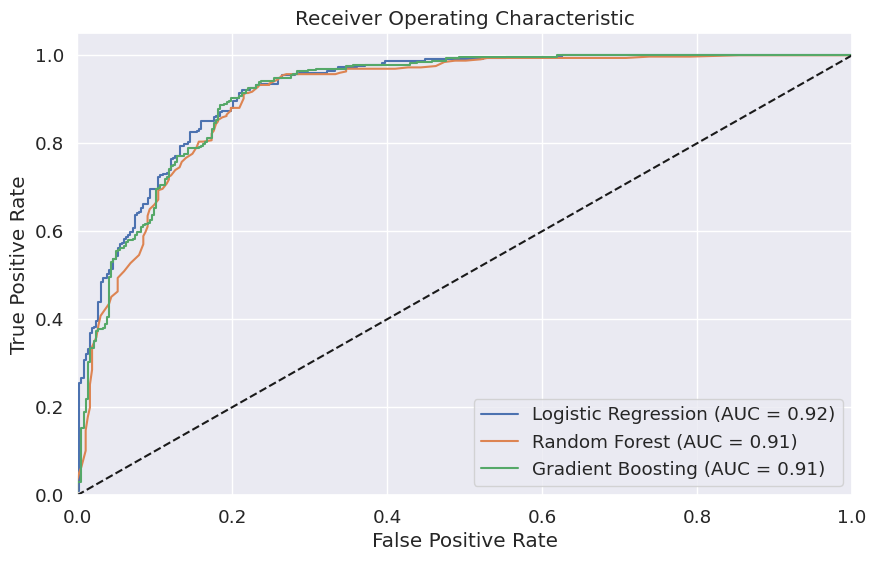

In [ ]:
# AUC é uma métrica bastante interessante para analisar o desempenho do modelo em distinguir duas classes

probs_LR = modeloLR.predict_proba(x_valid)[:, 1]
probs_RF = modeloRF.predict_proba(x_valid)[:, 1]
probs_GB = modeloGB.predict_proba(x_valid)[:, 1]

fpr_LR, tpr_LR, _ = roc_curve(y_valid, probs_LR)
fpr_RF, tpr_RF, _ = roc_curve(y_valid, probs_RF)
fpr_GB, tpr_GB, _ = roc_curve(y_valid, probs_GB)

roc_auc_LR = roc_auc_score(y_valid, probs_LR)
roc_auc_RF = roc_auc_score(y_valid, probs_RF)
roc_auc_GB = roc_auc_score(y_valid, probs_GB)

plt.figure(figsize=(10, 6))
plt.plot(fpr_LR, tpr_LR, label=f'Logistic Regression (AUC = {roc_auc_LR:.2f})')
plt.plot(fpr_RF, tpr_RF, label=f'Random Forest (AUC = {roc_auc_RF:.2f})')
plt.plot(fpr_GB, tpr_GB, label=f'Gradient Boosting (AUC = {roc_auc_GB:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


Para a escolha de um dos modelos, podemos seguir diferentes linhas de pensamento. Primeiramente, nossos dados não são desbalanceados, portanto não há uma exigência em priorizar métricas que se adaptem bem a esse tipo de cenário. Sendo assim, uma vez que se busca predizer corretamente todos os churns, evitando falsos negativos e também falsos positivos, que costumam implicar esforços desnecessários para se evitar o churn, sugerimos utilizar o Random Forest Classifier, que obteve o melhor balanço entre precisão (0.87) e recall (0.82).

Assim, com o modelo Logistic Regression, estimamos predizer 82% das saídas precoces de atletas da NBA. E de todas as predições de churn feitas, espera-se 85% serão corretas.